<a href="https://colab.research.google.com/github/EmaJuarezDev/CD-1C2025/blob/main/EXCEL_RANDOM_FOREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [ ]:
dff = pd.read_csv("https://raw.githubusercontent.com/Franxx20/ciencia-de-datos-tp-parcial/refs/heads/main/TP_Virus_Alumnos.csv", sep=",")
dff.head(5)

,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
0,9.0,Femenino,36.410602,Inactivo,0,3.139714,6.929112,63.712640,73.880613,15.087239,90.400193,2.015331,1.633836,51.411632,0
1,58.0,Masculino,115.507184,Inactivo,4,2.953914,4.660136,64.582610,73.669319,14.503106,90.817947,0.973317,-0.439358,1000000.000000,0
2,74.0,Masculino,81.249035,Activo,3,1.365200,3.005861,63.613454,75.103984,14.077988,91.741638,3.243344,0.380413,1000000.000000,1
3,NaN,Masculino,77.985589,No_declara,0,2.329285,4.344642,64.433115,73.402436,15.583846,91.741709,3.188290,-0.226046,NaN,0
4,1.0,Femenino,13.446208,Inactivo,0,-0.062975,3.938741,65.122602,75.007982,16.961593,90.668625,2.729202,0.589698,21.627303,1


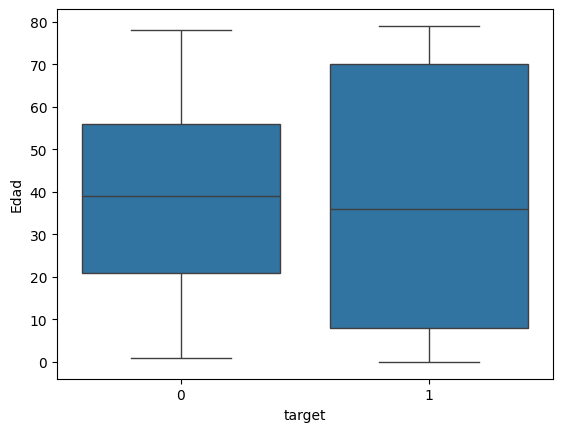

In [ ]:
# prompt: boxplot to target and edad

sns.boxplot(x="target", y="Edad", data=df)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer  # Necesario importar ANTES de IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier


# Configuración
# Leemos el dataset de entrenamiento
df_train = dff
df = df_train.copy()  # Trabajamos con una copia

# Mostrar información del dataset original
print("\nColumnas en el dataset original:")
print(df.columns.tolist())
print("\nPrimeras 5 filas del dataset original:")
print(df.head())
print("\nInformación del dataset original:")
print(df.info())

# 1. Preparar datos para la imputación KNN
# Convertir 'Laboral' a numérico usando LabelEncoder
label_encoder = LabelEncoder()

# Crear un imputador KNN solo para LVL
lvl_imputer = KNNImputer(n_neighbors=5)
# Usamos edad y peso para mejorar la imputación
df['LVL'] = lvl_imputer.fit_transform(df[['LVL', 'Edad', 'Peso']])[:, 0]


# Ahora categorizamos LVL en ALTO/BAJO
def categorize_lvl(x):
    return 'ALTO' if x > 500000 else 'BAJO'

df['LVL_CAT'] = df['LVL'].apply(categorize_lvl)
df = df.drop('LVL', axis=1)  # Eliminamos la columna original LVL

# Eliminar columna Genero
df = df.drop('Genero', axis=1)

# Identificar columnas para el pipeline
numeric_features = ['Edad']
categorical_features = ['Laboral', 'LVL_CAT']

# Obtener las demás columnas que no vamos a transformar
# Excluimos 'target' y las columnas que ya estamos procesando
other_features = [col for col in df.columns if col not in
                 numeric_features + categorical_features + ['target']]

print("\nColumnas que se procesarán específicamente:")
print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)
print("\nColumnas que se mantendrán sin transformar:", other_features)

# Para edad: Usamos IterativeImputer (también conocido como MICE)
age_imputer = IterativeImputer(
    max_iter=5,
    random_state=42,
    initial_strategy='mean'
)

# Transformadores
numeric_transformer = Pipeline([
    ('imputer', age_imputer)
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Crear el preprocesador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('pass', 'passthrough', other_features)  # Mantener las demás columnas sin transformar
    ])

# Antes de la transformación final, mostremos todas las categorías
print("\nCategorías originales en cada variable categórica:")
X_temp = df.drop("target", axis=1).copy()
for feature in categorical_features:
    print(f"\nCategorías únicas en {feature}:")
    print(X_temp[feature].unique())

# Mostrar cómo queda el dataset después del preprocesamiento
print("\nMostrando las primeras filas del dataset después del preprocesamiento:")
# Aplicar solo el preprocesador
X_transformed = preprocessor.fit_transform(df)

# Obtener los nombres de las columnas después del preprocesamiento
feature_names = (
    numeric_features +  # Columnas numéricas se mantienen igual
    [f"{feature}_{val}" for feature, vals in
     zip(categorical_features,
         preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_)
     for val in vals[1:]] +  # Excluimos la primera categoría por drop='first'
    other_features  # Añadimos las columnas sin transformar
)

# Convertir a DataFrame para mejor visualización
X_transformed_df = pd.DataFrame(
    X_transformed,
    columns=feature_names
)
print("\nPrimeras 5 filas del dataset transformado:")
print(X_transformed_df.head())
print("\nForma del dataset transformado:", X_transformed_df.shape)

# Preparar datos
X = df.drop("target", axis=1)
y = df["target"]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el pipeline base para RandomForest con GridSearchCV
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Crear el pipeline base para RandomForest con RandomizedSearchCV
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


# Hiperparámetros para GridSearchCV
param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10, 20],
    'classifier__min_samples_leaf': [2, 4, 6],
    'classifier__criterion': ['gini', 'entropy']
}

# Hiperparámetros para RandomizedSearchCV
rf_param_dist = {

    'classifier__n_estimators': [30,60,90,120,150,180,200,250],
    'classifier__max_depth': [None, 2, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross validation
    scoring='f1_weighted',  # Métrica para optimizar
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1  # Mostrar progreso
)

# Crear el RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)


# Entrenar el modelo con búsqueda de hiperparámetros
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print("\nMejor puntaje en la validación cruzada:", grid_search.best_score_)

# Evaluar en el conjunto de prueba
y_pred = grid_search.predict(X_test)
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Evaluar overfitting comparando rendimiento en train vs test
print("\n=== Análisis de Overfitting ===")
# Métricas en conjunto de entrenamiento
y_train_pred = grid_search.predict(X_train)
train_score = grid_search.score(X_train, y_train)
# Métricas en conjunto de test
test_score = grid_search.score(X_test, y_test)


# Diferencia entre train y test
print(f"\nDiferencia entre train y test: {train_score - test_score:.4f}")
print("(Una diferencia grande (>0.1) podría indicar overfitting)")

# Mostrar scores de CV para ver la variabilidad
cv_scores = grid_search.cv_results_['split0_test_score'], \
           grid_search.cv_results_['split1_test_score'], \
           grid_search.cv_results_['split2_test_score'], \
           grid_search.cv_results_['split3_test_score'], \
           grid_search.cv_results_['split4_test_score']

print("\nPuntajes en cada fold de CV para el mejor modelo:")
print(f"Media: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
print("(Una desviación estándar grande podría indicar inestabilidad en el modelo)")


Columnas en el dataset original:
['Edad', 'Genero', 'Peso', 'Laboral', 'hijos', 'BLD01', 'REC1', 'REC2', 'REC3', 'REC4', 'REC5', 'BLD02', 'BLD03', 'LVL', 'target']

Primeras 5 filas del dataset original:
   Edad     Genero        Peso     Laboral  hijos     BLD01      REC1  \
0   9.0   Femenino   36.410602    Inactivo      0  3.139714  6.929112   
1  58.0  Masculino  115.507184    Inactivo      4  2.953914  4.660136   
2  74.0  Masculino   81.249035      Activo      3  1.365200  3.005861   
3   NaN  Masculino   77.985589  No_declara      0  2.329285  4.344642   
4   1.0   Femenino   13.446208    Inactivo      0 -0.062975  3.938741   

        REC2       REC3       REC4       REC5     BLD02     BLD03  \
0  63.712640  73.880613  15.087239  90.400193  2.015331  1.633836   
1  64.582610  73.669319  14.503106  90.817947  0.973317 -0.439358   
2  63.613454  75.103984  14.077988  91.741638  3.243344  0.380413   
3  64.433115  73.402436  15.583846  91.741709  3.188290 -0.226046   
4  65.12260

In [ ]:
# Crear el pipeline base para RandomForest con RandomizedSearchCV
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])


# Hiperparámetros para RandomizedSearchCV
rf_param_dist = {

    'classifier__n_estimators': [90,100,110],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [ 5, 10],
    'classifier__min_samples_leaf': [4, 6, 8],
    'classifier__max_features': ["sqrt", "log2", None],
    'classifier__class_weight': ['balanced', {0:1,1:2}]
}

# Crear el RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo con búsqueda de hiperparámetros
print("\nIniciando búsqueda de hiperparámetros...")
random_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
print(random_search_rf.best_params_)
print("\nMejor puntaje en la validación cruzada:", random_search_rf.best_score_)

# Evaluar en el conjunto de prueba
y_pred_rs = random_search_rf.predict(X_test)
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred_rs))

# Evaluar overfitting comparando rendimiento en train vs test
print("\n=== Análisis de Overfitting ===")
# Métricas en conjunto de entrenamiento
y_train_pred_RS = random_search_rf.predict(X_train)
train_score_RS = random_search_rf.score(X_train, y_train)
# Métricas en conjunto de test
test_score_RS = random_search_rf.score(X_test, y_test)


# Diferencia entre train y test
print(f"\nDiferencia entre train y test: {train_score_RS - test_score_RS:.4f}")
print("(Una diferencia grande (>0.1) podría indicar overfitting)")

# Mostrar scores de CV para ver la variabilidad
cv_scores_RS = random_search_rf.cv_results_['split0_test_score'], \
           random_search_rf.cv_results_['split1_test_score'], \
           random_search_rf.cv_results_['split2_test_score'], \
           random_search_rf.cv_results_['split3_test_score'], \
           random_search_rf.cv_results_['split4_test_score']

print("\nPuntajes en cada fold de CV para el mejor modelo:")
print(f"Media: {np.mean(cv_scores_RS):.4f} (+/- {np.std(cv_scores_RS) * 2:.4f})")
print("(Una desviación estándar grande podría indicar inestabilidad en el modelo)")


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores parámetros encontrados:
{'classifier__n_estimators': 90, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': None, 'classifier__max_depth': 15, 'classifier__class_weight': 'balanced'}

Mejor puntaje en la validación cruzada: 0.7967387437056697

Informe de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       739
           1       0.76      0.71      0.74       521

    accuracy                           0.79      1260
   macro avg       0.79      0.78      0.78      1260
weighted avg       0.79      0.79      0.79      1260


=== Análisis de Overfitting ===

Diferencia entre train y test: 0.1386
(Una diferencia grande (>0.1) podría indicar overfitting)

Puntajes en cada fold de CV para el mejor modelo:
Media: 0.7885 (+/- 0.0344)
(Una desviaci

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer  # Necesario importar ANTES de IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier


# Configuración
# Leemos el dataset de entrenamiento
df_train = dff
df = df_train.copy()  # Trabajamos con una copia

# Mostrar información del dataset original
print("\nColumnas en el dataset original:")
print(df.columns.tolist())
print("\nPrimeras 5 filas del dataset original:")
print(df.head())
print("\nInformación del dataset original:")
print(df.info())

# 1. Preparar datos para la imputación KNN
# Convertir 'Laboral' a numérico usando LabelEncoder
label_encoder = LabelEncoder()

# Crear un imputador KNN solo para LVL
lvl_imputer = KNNImputer(n_neighbors=5)
# Usamos edad y peso para mejorar la imputación
df['LVL'] = lvl_imputer.fit_transform(df[['LVL', 'Edad', 'Peso']])[:, 0]


# Ahora categorizamos LVL en ALTO/BAJO
def categorize_lvl(x):
    return 'ALTO' if x > 500000 else 'BAJO'

df['LVL_CAT'] = df['LVL'].apply(categorize_lvl)
df = df.drop('LVL', axis=1)  # Eliminamos la columna original LVL

# Eliminar columna Genero
df = df.drop('Genero', axis=1)

# Identificar columnas para el pipeline
numeric_features = ['Edad']
categorical_features = ['Laboral', 'LVL_CAT']

# Obtener las demás columnas que no vamos a transformar
# Excluimos 'target' y las columnas que ya estamos procesando
other_features = [col for col in df.columns if col not in
                 numeric_features + categorical_features + ['target']]

print("\nColumnas que se procesarán específicamente:")
print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)
print("\nColumnas que se mantendrán sin transformar:", other_features)

# Para edad: Usamos IterativeImputer (también conocido como MICE)
age_imputer = IterativeImputer(
    max_iter=5,
    random_state=42,
    initial_strategy='mean'
)

# Transformadores
numeric_transformer = Pipeline([
    ('imputer', age_imputer)
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Crear el preprocesador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('pass', 'passthrough', other_features)  # Mantener las demás columnas sin transformar
    ])

# Antes de la transformación final, mostremos todas las categorías
print("\nCategorías originales en cada variable categórica:")
X_temp = df.drop("target", axis=1).copy()
for feature in categorical_features:
    print(f"\nCategorías únicas en {feature}:")
    print(X_temp[feature].unique())

# Mostrar cómo queda el dataset después del preprocesamiento
print("\nMostrando las primeras filas del dataset después del preprocesamiento:")
# Aplicar solo el preprocesador
X_transformed = preprocessor.fit_transform(df)

# Obtener los nombres de las columnas después del preprocesamiento
feature_names = (
    numeric_features +  # Columnas numéricas se mantienen igual
    [f"{feature}_{val}" for feature, vals in
     zip(categorical_features,
         preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_)
     for val in vals[1:]] +  # Excluimos la primera categoría por drop='first'
    other_features  # Añadimos las columnas sin transformar
)

# Convertir a DataFrame para mejor visualización
X_transformed_df = pd.DataFrame(
    X_transformed,
    columns=feature_names
)
print("\nPrimeras 5 filas del dataset transformado:")
print(X_transformed_df.head())
print("\nForma del dataset transformado:", X_transformed_df.shape)

# Preparar datos
X = df.drop("target", axis=1)
y = df["target"]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el pipeline base para RandomForest con GridSearchCV
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Crear el pipeline base para RandomForest con RandomizedSearchCV
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


# Hiperparámetros para GridSearchCV
param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10, 20],
    'classifier__min_samples_leaf': [2, 4, 6],
    'classifier__criterion': ['gini', 'entropy']
}

# Hiperparámetros para RandomizedSearchCV
rf_param_dist = {

    'classifier__n_estimators': [30,60,90,120,150,180,200,250],
    'classifier__max_depth': [None, 2, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross validation
    scoring='f1_weighted',  # Métrica para optimizar
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1  # Mostrar progreso
)

# Crear el RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    cv=5,
    scoring='precision',
    random_state=42,
    n_jobs=-1,
    verbose=1
)


# Entrenar el modelo con búsqueda de hiperparámetros
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print("\nMejor puntaje en la validación cruzada:", grid_search.best_score_)

# Evaluar en el conjunto de prueba
y_pred = grid_search.predict(X_test)
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Evaluar overfitting comparando rendimiento en train vs test
print("\n=== Análisis de Overfitting ===")
# Métricas en conjunto de entrenamiento
y_train_pred = grid_search.predict(X_train)
train_score = grid_search.score(X_train, y_train)
# Métricas en conjunto de test
test_score = grid_search.score(X_test, y_test)


# Diferencia entre train y test
print(f"\nDiferencia entre train y test: {train_score - test_score:.4f}")
print("(Una diferencia grande (>0.1) podría indicar overfitting)")

# Mostrar scores de CV para ver la variabilidad
cv_scores = grid_search.cv_results_['split0_test_score'], \
           grid_search.cv_results_['split1_test_score'], \
           grid_search.cv_results_['split2_test_score'], \
           grid_search.cv_results_['split3_test_score'], \
           grid_search.cv_results_['split4_test_score']

print("\nPuntajes en cada fold de CV para el mejor modelo:")
print(f"Media: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
print("(Una desviación estándar grande podría indicar inestabilidad en el modelo)")


Columnas en el dataset original:
['Edad', 'Genero', 'Peso', 'Laboral', 'hijos', 'BLD01', 'REC1', 'REC2', 'REC3', 'REC4', 'REC5', 'BLD02', 'BLD03', 'LVL', 'target']

Primeras 5 filas del dataset original:
   Edad     Genero        Peso     Laboral  hijos     BLD01      REC1  \
0   9.0   Femenino   36.410602    Inactivo      0  3.139714  6.929112   
1  58.0  Masculino  115.507184    Inactivo      4  2.953914  4.660136   
2  74.0  Masculino   81.249035      Activo      3  1.365200  3.005861   
3   NaN  Masculino   77.985589  No_declara      0  2.329285  4.344642   
4   1.0   Femenino   13.446208    Inactivo      0 -0.062975  3.938741   

        REC2       REC3       REC4       REC5     BLD02     BLD03  \
0  63.712640  73.880613  15.087239  90.400193  2.015331  1.633836   
1  64.582610  73.669319  14.503106  90.817947  0.973317 -0.439358   
2  63.613454  75.103984  14.077988  91.741638  3.243344  0.380413   
3  64.433115  73.402436  15.583846  91.741709  3.188290 -0.226046   
4  65.12260

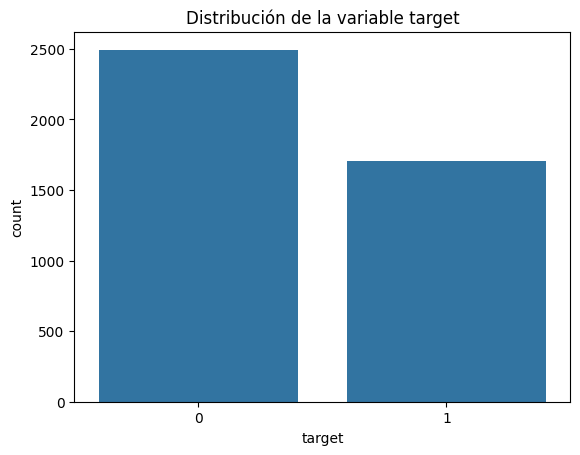


Frecuencia por clase:
target
0    0.593571
1    0.406429
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df)
plt.title("Distribución de la variable target")
plt.show()

print("\nFrecuencia por clase:")
print(df['target'].value_counts(normalize=True))

In [ ]:
# Crear el pipeline base para RandomForest con RandomizedSearchCV
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])


# Hiperparámetros para RandomizedSearchCV
rf_param_dist = {

    'classifier__n_estimators': [90,100,110],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [ 5, 10],
    'classifier__min_samples_leaf': [4, 6, 8],
    'classifier__max_features': ["sqrt", "log2", None],
    'classifier__class_weight': ['balanced', {0:1,1:2}]
}

# Crear el RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo con búsqueda de hiperparámetros
print("\nIniciando búsqueda de hiperparámetros...")
random_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
print(random_search_rf.best_params_)
print("\nMejor puntaje en la validación cruzada:", random_search_rf.best_score_)

# Evaluar en el conjunto de prueba
y_pred_rs = random_search_rf.predict(X_test)
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred_rs))

# Evaluar overfitting comparando rendimiento en train vs test
print("\n=== Análisis de Overfitting ===")
# Métricas en conjunto de entrenamiento
y_train_pred_RS = random_search_rf.predict(X_train)
train_score_RS = random_search_rf.score(X_train, y_train)
# Métricas en conjunto de test
test_score_RS = random_search_rf.score(X_test, y_test)


# Diferencia entre train y test
print(f"\nDiferencia entre train y test: {train_score_RS - test_score_RS:.4f}")
print("(Una diferencia grande (>0.1) podría indicar overfitting)")

# Mostrar scores de CV para ver la variabilidad
cv_scores_RS = random_search_rf.cv_results_['split0_test_score'], \
           random_search_rf.cv_results_['split1_test_score'], \
           random_search_rf.cv_results_['split2_test_score'], \
           random_search_rf.cv_results_['split3_test_score'], \
           random_search_rf.cv_results_['split4_test_score']

print("\nPuntajes en cada fold de CV para el mejor modelo:")
print(f"Media: {np.mean(cv_scores_RS):.4f} (+/- {np.std(cv_scores_RS) * 2:.4f})")
print("(Una desviación estándar grande podría indicar inestabilidad en el modelo)")


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores parámetros encontrados:
{'classifier__n_estimators': 90, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': None, 'classifier__max_depth': 15, 'classifier__class_weight': 'balanced'}

Mejor puntaje en la validación cruzada: 0.7967387437056697

Informe de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       739
           1       0.76      0.71      0.74       521

    accuracy                           0.79      1260
   macro avg       0.79      0.78      0.78      1260
weighted avg       0.79      0.79      0.79      1260


=== Análisis de Overfitting ===

Diferencia entre train y test: 0.1386
(Una diferencia grande (>0.1) podría indicar overfitting)

Puntajes en cada fold de CV para el mejor modelo:
Media: 0.7885 (+/- 0.0344)
(Una desviaci

In [ ]:
# prompt: best this code rf_param_dist = {
#     'classifier__n_estimators': [90,100,110],
#     'classifier__max_depth': [5, 10, 15],
#     'classifier__min_samples_split': [ 5, 10],
#     'classifier__min_samples_leaf': [4, 6, 8],
#     'classifier__max_features': ["sqrt", "log2", None],
#     'classifier__class_weight': ['balanced', {0:1,1:2}]
# }

# Hiperparámetros para RandomizedSearchCV
rf_param_dist = {
    'classifier__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)], # Broader range
    'classifier__max_depth': [None] + [int(x) for x in np.linspace(10, 110, num = 11)], # Broader range including None
    'classifier__min_samples_split': [2, 5, 10, 15, 20], # Add more values
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8, 10], # Add more values
    'classifier__max_features': ["sqrt", "log2", None, 0.5, 0.7], # Include float values
    'classifier__class_weight': ['balanced', {0:1,1:2}, {0:1, 1:5}, {0:1, 1:10}] # Add more weight options
}

# Ensure 'criterion' is in the pipeline if you want to tune it via RandomizedSearchCV
# Currently, 'criterion' is in the rf_param_dist but not explicitly in the base rf_pipeline's classifier.
# It should be part of the classifier's parameters, not the pipeline's.
# Let's update rf_param_dist assuming 'criterion' is a valid parameter for RandomForestClassifier
# (which it is, but the way it was listed before was a bit ambiguous with the prefix)

rf_param_dist = {
    'classifier__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
    'classifier__max_depth': [None] + [int(x) for x in np.linspace(10, 110, num = 11)],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'classifier__max_features': ["sqrt", "log2", None, 0.5, 0.7],
    'classifier__class_weight': ['balanced', {0:1,1:2}, {0:1, 1:5}, {0:1, 1:10}],
    'classifier__criterion': ['gini', 'entropy'] # Tune criterion as well
}

# Create the RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    n_iter=100, # Increase the number of iterations for a wider search
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo con búsqueda de hiperparámetros
print("\nIniciando búsqueda de hiperparámetros...")
random_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
print(random_search_rf.best_params_)
print("\nMejor puntaje en la validación cruzada:", random_search_rf.best_score_)

# Evaluar en el conjunto de prueba
y_pred_rs = random_search_rf.predict(X_test)
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred_rs))

# Evaluar overfitting comparando rendimiento en train vs test
print("\n=== Análisis de Overfitting ===")
# Métricas en conjunto de entrenamiento
y_train_pred_RS = random_search_rf.predict(X_train)
train_score_RS = random_search_rf.score(X_train, y_train)
# Métricas en conjunto de test
test_score_RS = random_search_rf.score(X_test, y_test)


# Diferencia entre train y test
print(f"\nDiferencia entre train y test: {train_score_RS - test_score_RS:.4f}")
print("(Una diferencia grande (>0.1) podría indicar overfitting)")

# Mostrar scores de CV para ver la variabilidad
cv_scores_RS = random_search_rf.cv_results_['split0_test_score'], \
           random_search_rf.cv_results_['split1_test_score'], \
           random_search_rf.cv_results_['split2_test_score'], \
           random_search_rf.cv_results_['split3_test_score'], \
           random_search_rf.cv_results_['split4_test_score']

print("\nPuntajes en cada fold de CV para el mejor modelo:")
print(f"Media: {np.mean(cv_scores_RS):.4f} (+/- {np.std(cv_scores_RS) * 2:.4f})")
print("(Una desviación estándar grande podría indicar inestabilidad en el modelo)")



Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejores parámetros encontrados:
{'classifier__n_estimators': 115, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 0.7, 'classifier__max_depth': 70, 'classifier__criterion': 'entropy', 'classifier__class_weight': {0: 1, 1: 2}}

Mejor puntaje en la validación cruzada: 0.7987580773900601

Informe de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       739
           1       0.77      0.71      0.74       521

    accuracy                           0.79      1260
   macro avg       0.79      0.78      0.78      1260
weighted avg       0.79      0.79      0.79      1260


=== Análisis de Overfitting ===

Diferencia entre train y test: 0.1914
(Una diferencia grande (>0.1) podría indicar overfitting)

Puntajes en cada fold de CV para el mejor modelo: